In [1]:
import sys
import os
os.chdir("/home/debian/PhenPred")
import importlib
import torch
import PhenPred
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
from PhenPred.vae import shap_folder, plot_folder
import Shap_functions
from PhenPred.vae.Train import CLinesTrain
from PhenPred.vae.Hypers import Hypers
from PhenPred.vae.DatasetDepMap23Q2 import CLinesDatasetDepMap23Q2

/home/debian/miniconda3/envs/mosa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(Shap_functions)

<module 'Shap_functions' from '/home/debian/PhenPred/PhenPred/vae/ShapAnalysis/Shap_functions.py'>

In [3]:
# order of explanation arrays
# proteomics, metabolomics, drugrespose, crisprcas9, methylation, transcriptomics, copynumber, conditionals
omics_dict = {
    "proteomics": 0,
    "metabolomics": 1,
    "drugrespose": 2,
    "crisprcas9": 3,
    "methylation": 4,
    "transcriptomics": 5,
    "copynumber": 6,
    "conditionals": 7
}

In [4]:
time_alldat = "20240805_132345" #all datasets, no dipvae
time_alldat_dis = "20240805_131847" #all datasets w/ disentanglement, lambda_d = 0.001, lambda_od = 0.001

target_latent = "latent"
target_drug = "drugresponse"

In [5]:
with open(f"{shap_folder}/files/{time_alldat_dis}_explanation_{target_latent}.pkl", 'rb') as f:
    explanation = pickle.load(f)

In [6]:
hyperparameters = Hypers.read_hyperparameters(timestamp=time_alldat_dis)

# Load the first dataset
clines_db = CLinesDatasetDepMap23Q2(
    labels_names=hyperparameters["labels"],
    datasets=hyperparameters["datasets"],
    feature_miss_rate_thres=hyperparameters["feature_miss_rate_thres"],
    standardize=hyperparameters["standardize"],
    filter_features=hyperparameters["filter_features"],
    filtered_encoder_only=hyperparameters["filtered_encoder_only"],
)

# Train and predictions
train = CLinesTrain(
    clines_db,
    hyperparameters,
    stratify_cv_by=clines_db.samples_by_tissue("Haematopoietic and Lymphoid"),
    timestamp=time_alldat_dis,
)

# ---- Hyperparameters
{
    "activation_function": "prelu",
    "batch_norm": false,
    "batch_size": 76,
    "contrastive_neg_margin": 0.15,
    "contrastive_pos_margin": 0.85,
    "dataname": "depmap23Q2",
    "datasets": {
        "copynumber": "/home/debian/PhenPred/data/clines//cnv_summary_20230303_matrix.csv",
        "crisprcas9": "/home/debian/PhenPred/data/clines//depmap23Q2/CRISPRGeneEffect.csv",
        "drugresponse": "/home/debian/PhenPred/data/clines//drugresponse.csv",
        "metabolomics": "/home/debian/PhenPred/data/clines//metabolomics.csv",
        "methylation": "/home/debian/PhenPred/data/clines//methylation.csv",
        "proteomics": "/home/debian/PhenPred/data/clines//proteomics.csv",
        "transcriptomics": "/home/debian/PhenPred/data/clines//depmap23Q2/OmicsExpressionGenesExpectedCountProfileVoom.csv"
    },
    "dip_vae_type": "ii",
    "feature_dropout": 0,
    "feature_miss_rate_thres": 0.85,
    "filter_features": [
        "transcriptomics",
      

/home/debian/PhenPred/PhenPred/vae/DatasetDepMap23Q2.py:234: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.labels = self.labels.reindex(index=self.samples).fillna(0)


In [7]:
sample_IDs = np.array(clines_db.samples)

In [6]:
shap_df = train.save_shap(explanation.values, target_latent)
columns_to_convert = shap_df.columns[2:]
shap_df[columns_to_convert] = shap_df[columns_to_convert].astype('float32')

In [8]:
shap_df

,target_name,Sample ID,proteomics_AAAS,proteomics_AACS,proteomics_AAGAB,proteomics_AAK1,proteomics_AAMDC,proteomics_AAMP,proteomics_AARS1,proteomics_AARS2,...,conditionals_mut_WNK4,conditionals_mut_WRN,conditionals_mut_ZEB1,conditionals_mut_ZFHX3,conditionals_mut_ZNF208,conditionals_mut_ZNF429,conditionals_mut_ZNF626,conditionals_mut_ZNF93,conditionals_mut_ZNRF3,conditionals_msi_status
0,Latent_1,SIDM00001,-0.000003,0.000003,1.510000e-05,1.000000e-07,-2.100000e-06,-0.000028,1.820000e-05,-0.000006,...,0.000000e+00,0.000000,5.000000e-07,-0.000001,0.000000,0.000010,0.000007,0.000003,0.000000,0.0
1,Latent_1,SIDM00003,0.000031,0.000002,-3.600000e-06,1.080000e-05,-2.100000e-06,0.000030,-9.000000e-07,0.000031,...,0.000000e+00,0.000000,0.000000e+00,-0.000072,0.000015,0.000000,0.000000,0.000006,0.000000,0.0
2,Latent_1,SIDM00005,0.000001,0.000003,-1.370000e-05,1.150000e-05,-1.120000e-05,0.000012,9.900000e-06,0.000001,...,-3.100000e-06,-0.000005,0.000000e+00,0.000001,0.000008,0.000007,0.000002,0.000002,0.000000,0.0
3,Latent_1,SIDM00006,-0.000014,-0.000005,-4.100000e-06,-1.080000e-05,3.700000e-06,-0.000019,3.500000e-06,0.000030,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000011,0.000000,0.000000,0.000000,0.000000,0.0
4,Latent_1,SIDM00007,0.000029,0.000006,1.590000e-05,3.290000e-05,-2.000000e-07,0.000015,2.490000e-05,0.000004,...,1.300000e-06,-0.000014,-6.000000e-07,-0.000029,0.000027,0.000000,0.000001,0.000004,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,Latent_215,SIDM01979,0.000002,-0.000003,-0.000000e+00,2.200000e-06,-1.570000e-05,0.000023,-2.690000e-05,-0.000001,...,1.600000e-06,0.000000,0.000000e+00,0.000026,0.000002,0.000000,0.000000,-0.000001,0.000007,0.0
1519,Latent_215,SIDM01980,0.000012,0.000017,-1.110000e-05,1.110000e-05,-2.300000e-06,0.000009,-1.000000e-05,-0.000024,...,-2.000000e-07,0.000000,6.200000e-06,0.000014,0.000000,0.000002,0.000000,-0.000003,0.000005,0.0
1520,Latent_215,SIDM01981,0.000002,0.000015,1.700000e-06,7.600000e-06,8.400000e-06,0.000021,-8.900000e-06,0.000057,...,-6.800000e-06,0.000000,0.000000e+00,0.000016,0.000000,-0.000003,0.000000,0.000000,0.000010,0.0
1521,Latent_215,SIDM01983,-0.000007,-0.000012,-6.000000e-07,2.900000e-06,2.800000e-06,-0.000008,-1.250000e-05,-0.000029,...,0.000000e+00,0.000000,0.000000e+00,0.000025,0.000013,0.000001,0.000010,0.000000,0.000000,0.0


Group Absolute SHAP values by (feature, latent dimensions)

In [9]:
# This consumes a lot of RAM!
absmean_shap_lat = Shap_functions.meanabs_groupby_feature_target(shap_df)
absmean_shap_lat.to_feather('/home/debian/PhenPred/PhenPred/vae/ShapAnalysis/absmean_shap_alldat_lat_withdipvae.feather') 

In [9]:
absmean_shap_lat = pd.read_feather('/home/debian/PhenPred/PhenPred/vae/ShapAnalysis/absmean_shap_alldat_lat_withdipvae.feather')

In [8]:
absmean_shap_lat.sort_values(by='Mean Abs Shap Values', ascending=False).head(50) 

Mean Abs Shap Values
Features                                        target_name                      
conditionals_tissue_Haematopoietic and Lymphoid Latent_150               0.135023
                                                Latent_61                0.090610
conditionals_mut_TP53                           Latent_108               0.085318
conditionals_tissue_Haematopoietic and Lymphoid Latent_57                0.076451
                                                Latent_12                0.066356
                                                Latent_203               0.060109
copynumber_RSPH10B2                             Latent_26                0.057154
conditionals_tissue_Lung                        Latent_108               0.053562
conditionals_tissue_Haematopoietic and Lymphoid Latent_93                0.051891
                                                Latent_48                0.051818
                                                Latent_205               0.049046
copynumber_RSPH10B2                             Latent_157               0.047863
conditionals_tissue_Haematopoietic and Lymphoid Latent_157               0.047106
copynumber_RSPH10B2                             Latent_182               0.045118
conditionals_tissue_Haematopoietic and Lymphoid Latent_108               0.043803
                                                Latent_134               0.043587
conditionals_day4_day1_ratio                    Latent_108               0.042381
copynumber_PTPN13                               Latent_108               0.040468
drugresponse_1430;IGFR_3801;GDSC1               Latent_108               0.039110
copynumber_NPEPPS                               Latent_108               0.038461
conditionals_tissue_Haematopoietic and Lymphoid Latent_94                0.036801
                                                Latent_59                0.036724
copynumber_RSPH10B2                             Latent_108               0.036426
conditionals_tissue_Haematopoietic and Lymphoid Latent_168               0.035777
                                                Latent_37                0.035397
                                                Latent_64                0.034830
copynumber_RSPH10B2                             Latent_34                0.033899
copynumber_CDKN2A                               Latent_108               0.033630
copynumber_RUNX1T1                              Latent_108               0.033612
drugresponse_1937;S-crizotinib;GDSC2            Latent_108               0.032992
conditionals_tissue_Haematopoietic and Lymphoid Latent_6                 0.032577
                                                Latent_187               0.032242
copynumber_RSPH10B2                             Latent_77                0.032023
copynumber_PSIP1                                Latent_108               0.031384
conditionals_tissue_Haematopoietic and Lymphoid Latent_208               0.030977
copynumber_FAT1                                 Latent_108               0.030772
copynumber_TBL1XR1                              Latent_108               0.030408
copynumber_RSPH10B2                             Latent_146               0.030260
conditionals_tissue_Haematopoietic and Lymphoid Latent_28                0.030056
drugresponse_1085;Sorafenib;GDSC2               Latent_108               0.029542
copynumber_ZMYM2                                Latent_108               0.029410
drugresponse_376;Brivanib, BMS-540215;GDSC1     Latent_108               0.029160
copynumber_RSPH10B2                             Latent_177               0.029143
                                                Latent_153               0.028713
conditionals_tissue_Haematopoietic and Lymphoid Latent_158               0.028528
drugresponse_476;SB505124;GDSC1                 Latent_108               0.028012
conditionals_tissue_Haematopoietic and Lymphoid Latent_190               0.027704
drugresponse_346;THZ-2-102-1;GDSC1         

In [35]:
# Without dominant latent dimensions
df = absmean_shap_lat.reset_index()
df[(df.target_name != "Latent_108") & (df.target_name != "Latent_106")].sort_values(by='Mean Abs Shap Values', ascending=False).head(50) 

,Features,target_name,Mean Abs Shap Values
46497,conditionals_tissue_Haematopoietic and Lymphoid,Latent_150,0.135023
46613,conditionals_tissue_Haematopoietic and Lymphoid,Latent_61,0.090610
46608,conditionals_tissue_Haematopoietic and Lymphoid,Latent_57,0.076451
46463,conditionals_tissue_Haematopoietic and Lymphoid,Latent_12,0.066356
46556,conditionals_tissue_Haematopoietic and Lymphoid,Latent_203,0.060109
180734,copynumber_RSPH10B2,Latent_26,0.057154
46648,conditionals_tissue_Haematopoietic and Lymphoid,Latent_93,0.051891
46598,conditionals_tissue_Haematopoietic and Lymphoid,Latent_48,0.051818
46558,conditionals_tissue_Haematopoietic and Lymphoid,Latent_205,0.049046
180664,copynumber_RSPH10B2,Latent_157,0.047863


In [59]:
df = absmean_shap_lat.reset_index()
df = df[(df.target_name != "Latent_108") & (df.target_name != "Latent_106")].sort_values(by='Mean Abs Shap Values', ascending=False)

values_to_find = ["conditionals_mut_TP53", "conditionals_day4_day1_ratio"]

for value_to_find in values_to_find:
    # Finding the index of the first occurrence of the specified value in the 'Features' column
    first_occurrence_index = df[df['Features'] == value_to_find].index[0]

    # Displaying the row corresponding to the first occurrence
    first_occurrence_row = df.loc[first_occurrence_index]
    print(first_occurrence_row)


Features                conditionals_mut_TP53
target_name                        Latent_183
Mean Abs Shap Values                 0.025254
Name: 40513, dtype: object
Features                conditionals_day4_day1_ratio
target_name                               Latent_183
Mean Abs Shap Values                        0.021304
Name: 93, dtype: object


Heatmap with features in the top x pairs

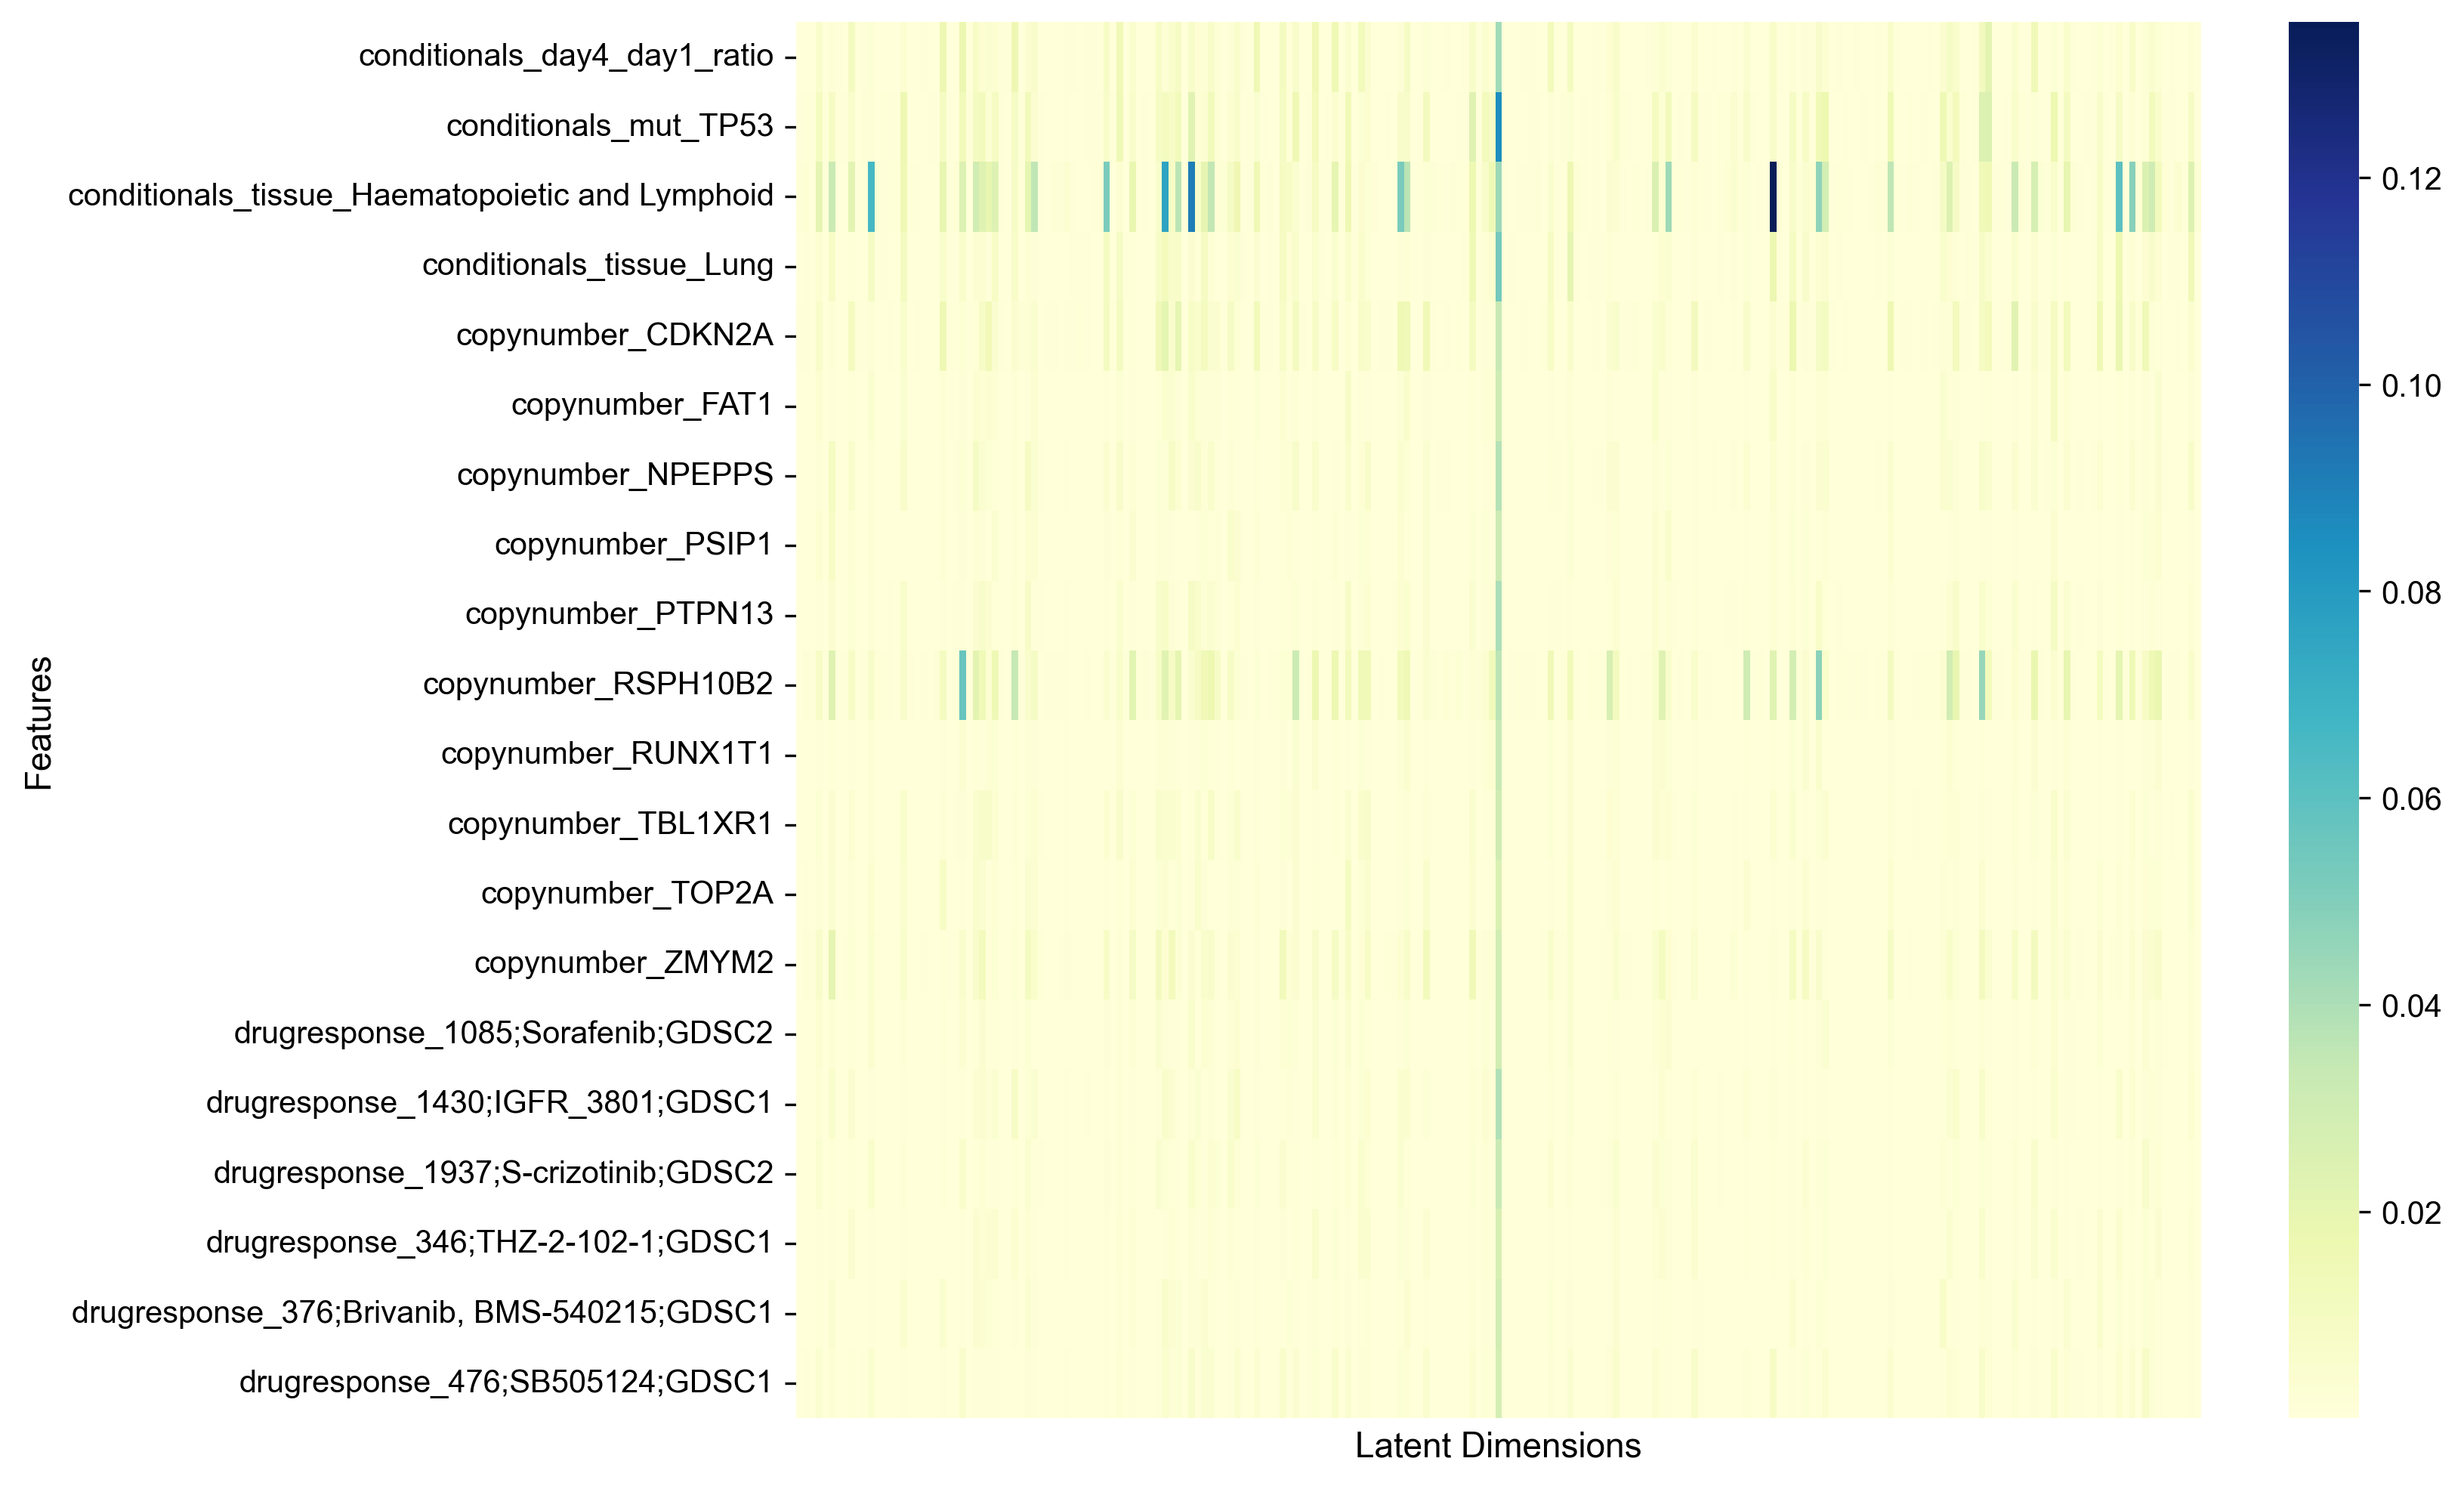

In [60]:
# top 50
Shap_functions.heatmap_features_vs_latents(50, absmean_shap_lat)

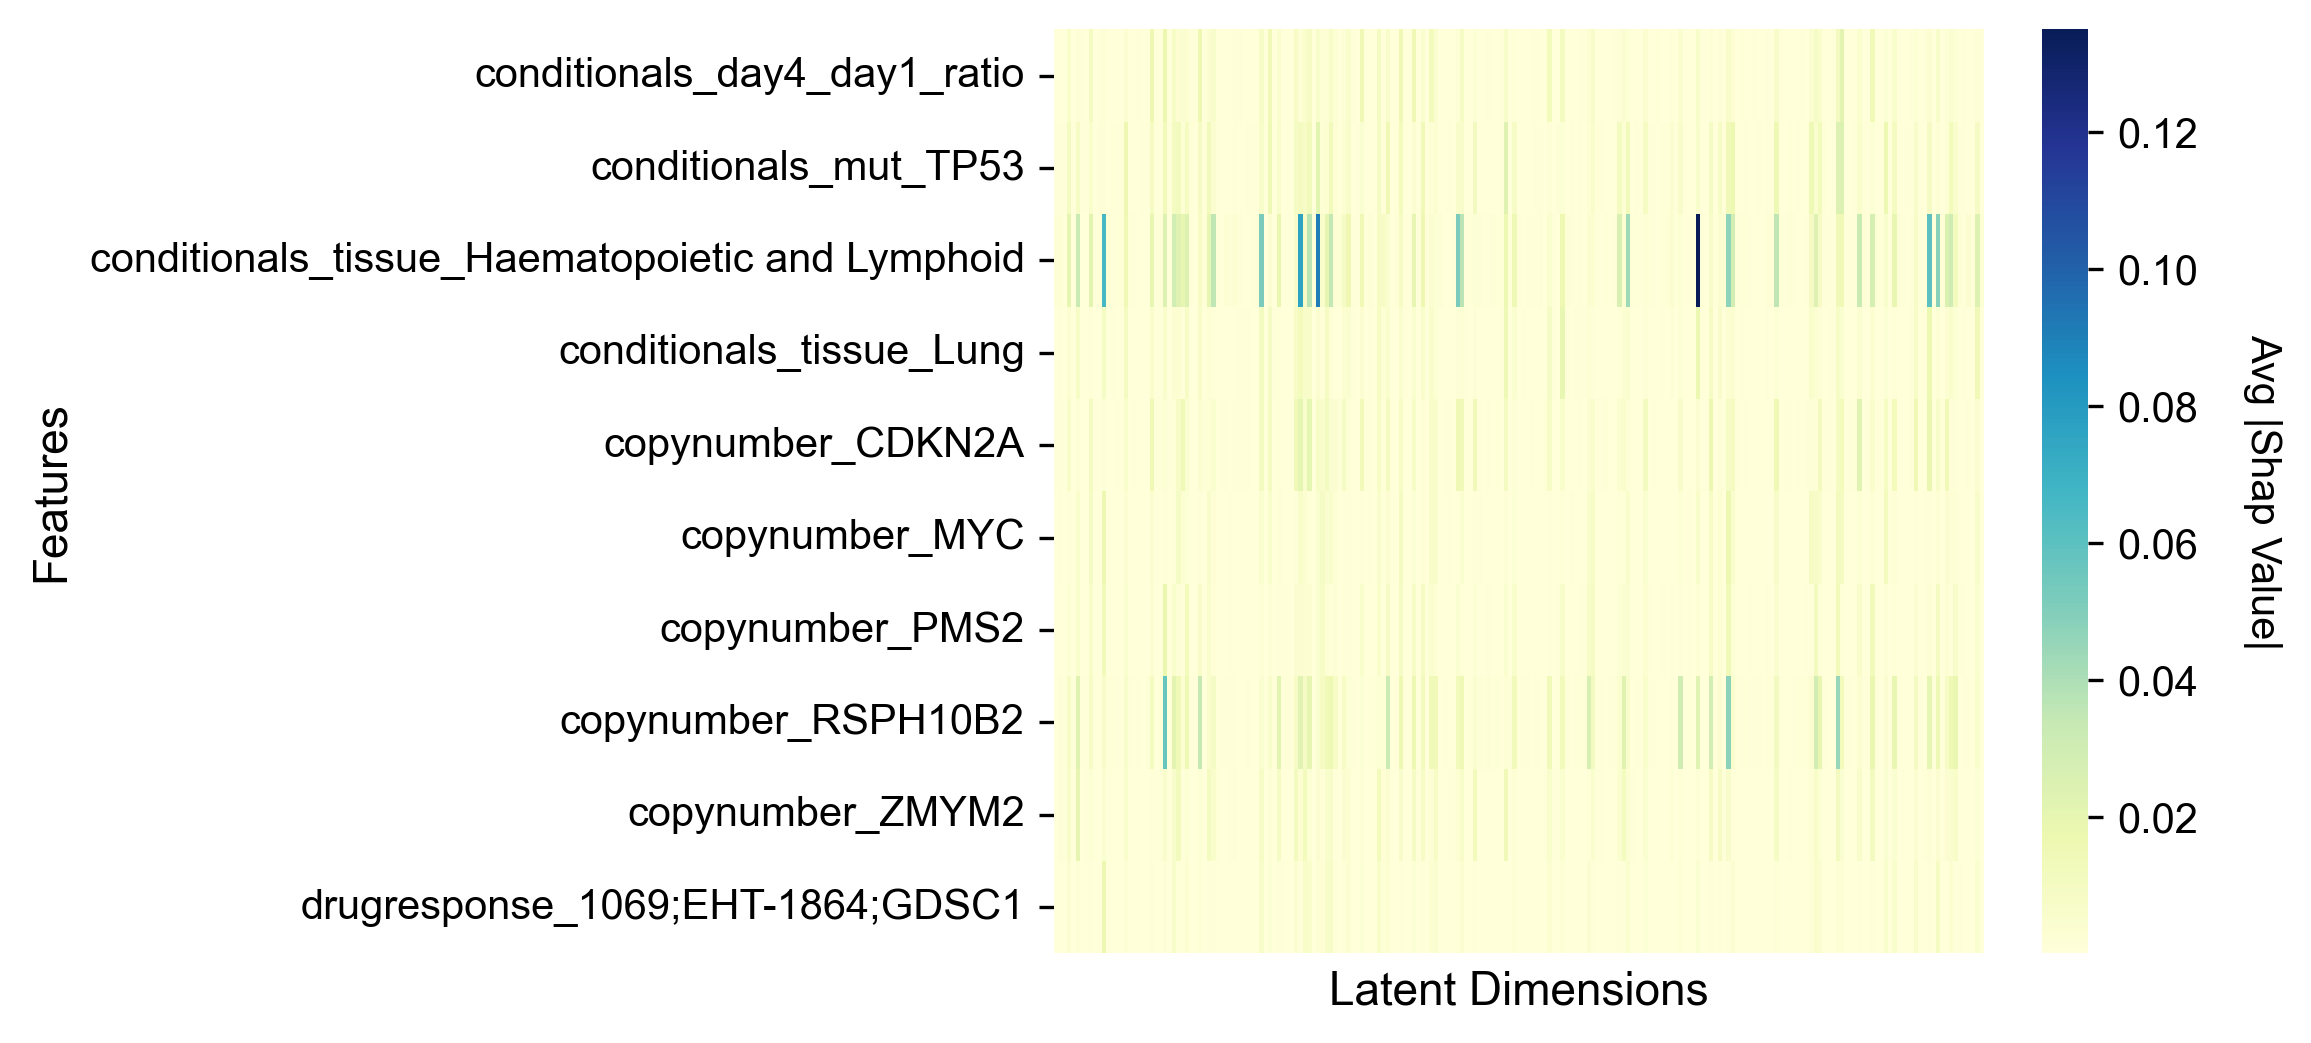

In [11]:
# top 100
# After dropping dominant latents
df = absmean_shap_lat.reset_index()
Shap_functions.heatmap_features_vs_latents(100, df[(df.target_name != "Latent_108") & (df.target_name != "Latent_106")])

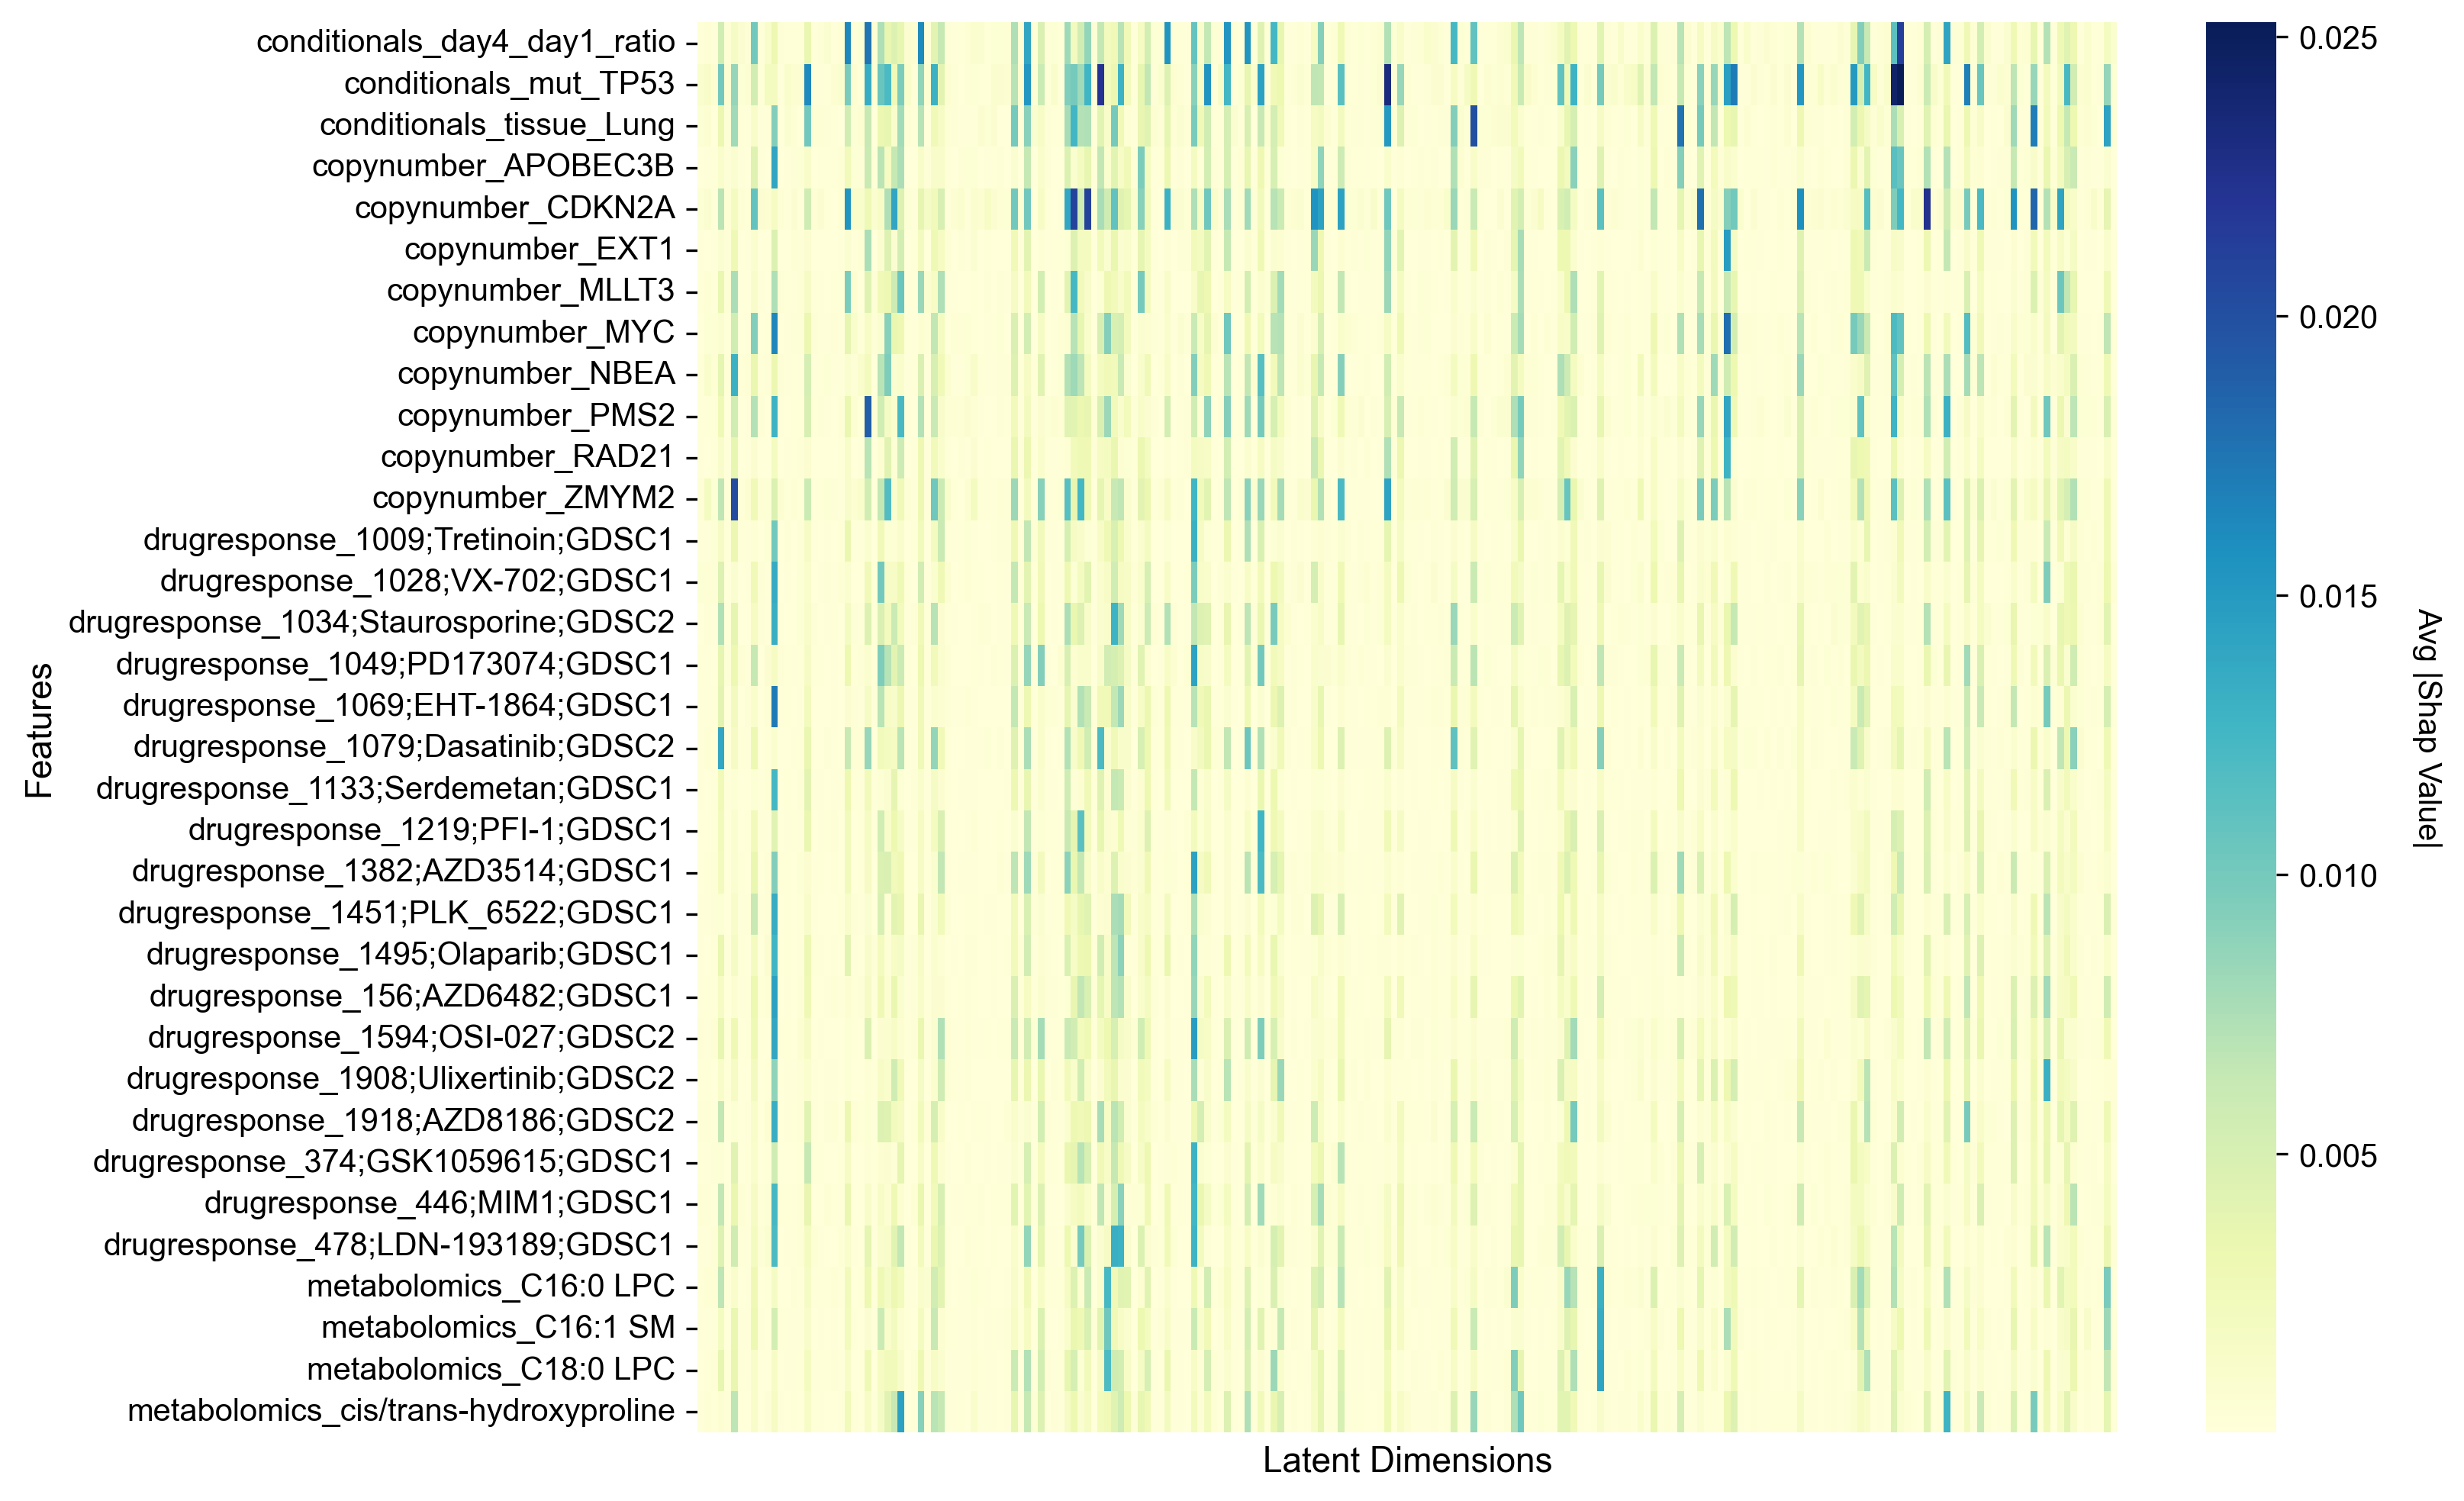

In [9]:
# After dropping latent 106 and 189 and features conditionals_tissue_Haematopoietic and Lymphoid and copynumber_RSPH10B2
df = absmean_shap_lat.reset_index()
Shap_functions.heatmap_features_vs_latents(100, df[(df.target_name != "Latent_108") & (df.target_name != "Latent_106") & (df.Features != "conditionals_tissue_Haematopoietic and Lymphoid") & (df.Features != "copynumber_RSPH10B2")])

Beeswarm plots

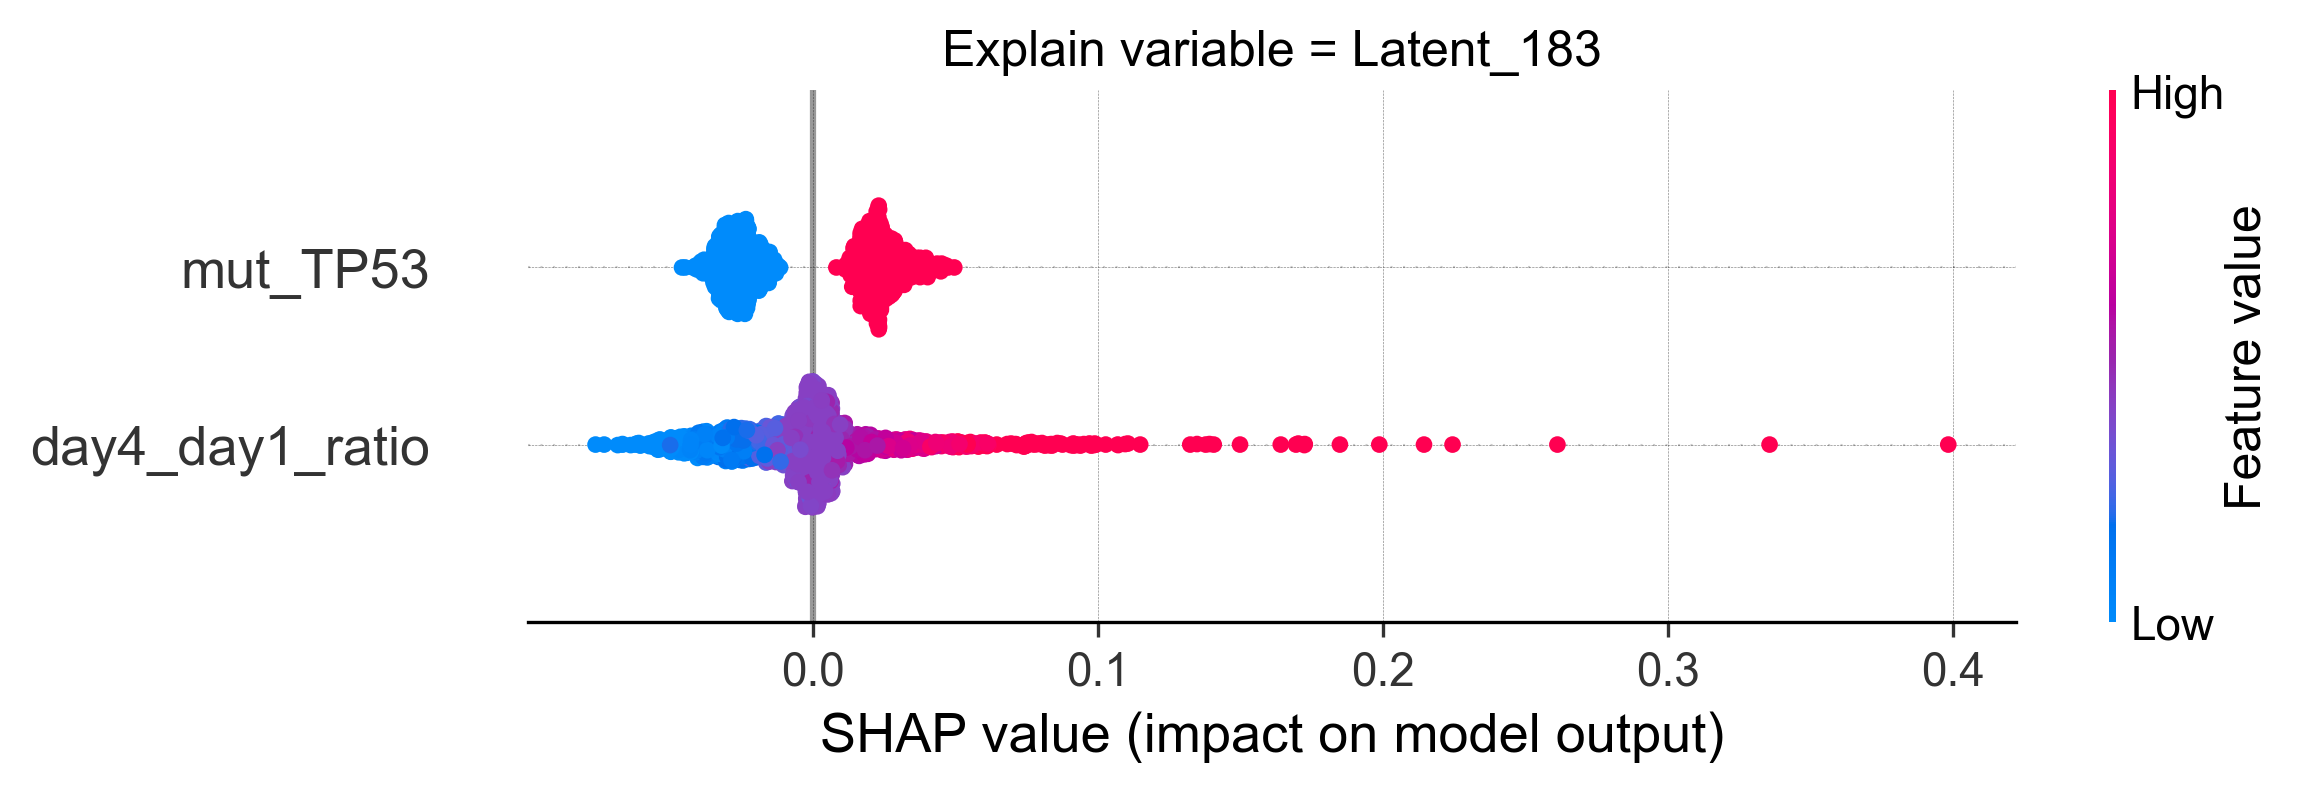

In [14]:
explain_targets_idx = [183]
explain_targets = [f"Latent_{i}" for i in explain_targets_idx]
explain_targets_and_idx = {key: value-1 for key, value in zip(explain_targets, explain_targets_idx)}

for explain_target in explain_targets:
    plt.title(f'Explain variable = {explain_target}', fontsize = 12)
    shap.plots.beeswarm(explanation[omics_dict["conditionals"]][:, ["mut_TP53", "day4_day1_ratio"], explain_targets_and_idx[explain_target]])
    plt.show()